In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms,models
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm_notebook
from IPython.core.display import HTML,display
from PIL import Image

In [2]:
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
def image_dir(dir_name):
    
    for dirpaths,dirnames,filenames in os.walk(dir_name):
        text = f'len dirnames : {len(dirnames)} len filenames : {len(filenames)} image path : {dirpaths}'
        print(text)

In [4]:
image_dir('/kaggle/input')

len dirnames : 1 len filenames : 0 image path : /kaggle/input
len dirnames : 1 len filenames : 0 image path : /kaggle/input/vegetable-image-dataset
len dirnames : 3 len filenames : 0 image path : /kaggle/input/vegetable-image-dataset/Vegetable Images
len dirnames : 15 len filenames : 0 image path : /kaggle/input/vegetable-image-dataset/Vegetable Images/validation
len dirnames : 0 len filenames : 200 image path : /kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli
len dirnames : 0 len filenames : 200 image path : /kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Capsicum
len dirnames : 0 len filenames : 200 image path : /kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Bottle_Gourd
len dirnames : 0 len filenames : 200 image path : /kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Radish
len dirnames : 0 len filenames : 200 image path : /kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Tomato
len dirna

In [5]:
test_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'
train_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
valid_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'


In [6]:
def image_show(target_dir):
    target_class = random.choice(os.listdir(target_dir))
    print(target_class)
    target_folder = os.path.join(target_dir,target_class)
    print(target_folder)
    random_image = random.sample(os.listdir(target_folder),5)
    print(random_image)
    
    plt.figure(figsize=(16,4))
    for i in range(5):
        
        plt.subplot(1,6,i+1)

        img = torchvision.io.read_image(os.path.join(target_folder, random_image[i]))
        plt.imshow(np.array(img).transpose(1,2,0))
        plt.title(f'{target_class}\n{np.array(img).shape}')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()
    
    

Capsicum
/kaggle/input/vegetable-image-dataset/Vegetable Images/train/Capsicum
['0345.jpg', '0154.jpg', '0949.jpg', '0692.jpg', '0421.jpg']


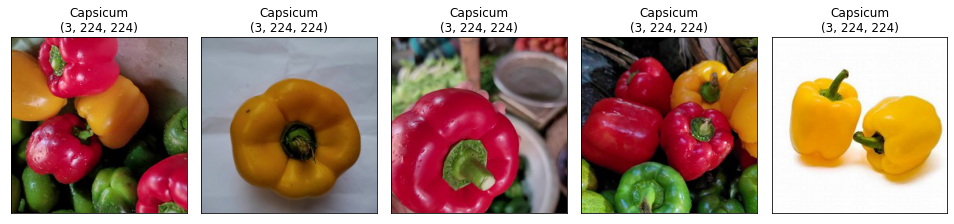

In [7]:
image_show(train_dir)

# 이미지전처리(트랜스폼)

In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.2, hue=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.2,0.2)),
    transforms.GaussianBlur(kernel_size=(5,9)),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])    
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])    
])

# 데이타셋

In [9]:
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform = train_transform)
valid_dataset = torchvision.datasets.ImageFolder(root=valid_dir, transform = test_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform = test_transform)

# 이미지 증강

In [10]:
mean=[0.485,0.456,0.406]
std=[0.229,0.224,0.225]
augmentation_list=[transforms.RandomHorizontalFlip(p=1.0),
                   transforms.RandomRotation(15),
                   transforms.ColorJitter(brightness=0.2,contrast=0.1,hue=0.1,saturation=0.1),
                   transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.5, 1.5), shear=15),
                   transforms.GaussianBlur(kernel_size=(5,9)),
                   transforms.Normalize(mean,std)
                  ]
                

In [11]:
def origin_and_aug_image_show(target_dir,aug_list):
    
    n=len(aug_list)
    print(n)
    target_class = random.choice(os.listdir(target_dir))
    print(target_class)
    target_folder = os.path.join(target_dir,target_class)
    print(target_folder)
    random_image = random.sample(os.listdir(target_folder),n)
    
    for i in range(n):
        plt.figure(figsize=(16,6))
        augmentation=aug_list[i]
        plt.subplot(1,2,1)
        img=torchvision.io.read_image(os.path.join(target_folder,random_image[i]))
        img=img/255.0 # rescale 0-255분포된 rgb값은 모델이 처리하기 힘들기 때문에 0과1사이의 값으로 스케일링 
        plt.imshow(np.array(img).transpose(1,2,0))
        plt.title(f'Origin Image\n{target_class}\n{np.array(img).shape}')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,2,2)

        img=augmentation(img)
        
        
        plt.imshow(np.array(img).transpose(1,2,0))
        plt.title(f'aug image:{augmentation}\n{target_class}\n{np.array(img).shape}')
        plt.xticks([])
        plt.yticks([])
        plt.show()
    
    

6
Radish
/kaggle/input/vegetable-image-dataset/Vegetable Images/train/Radish


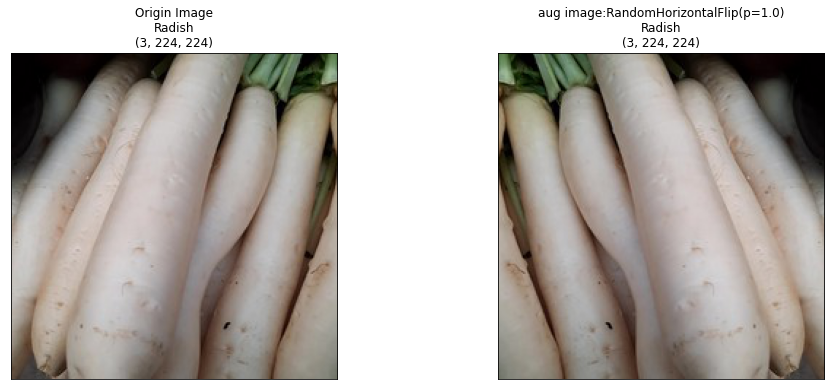

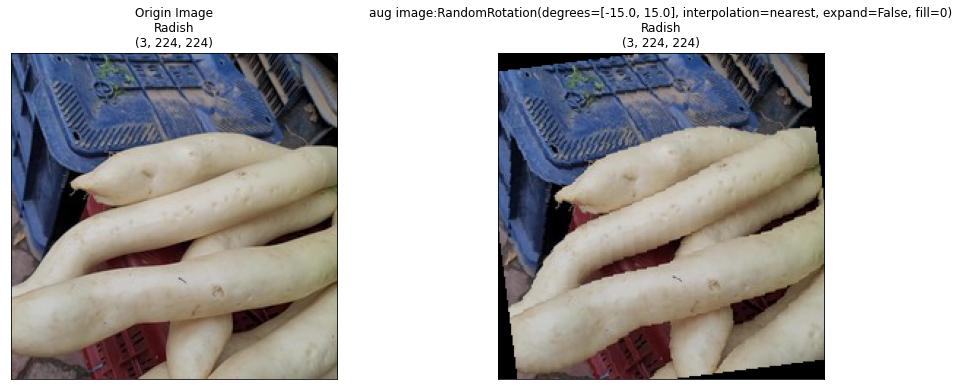

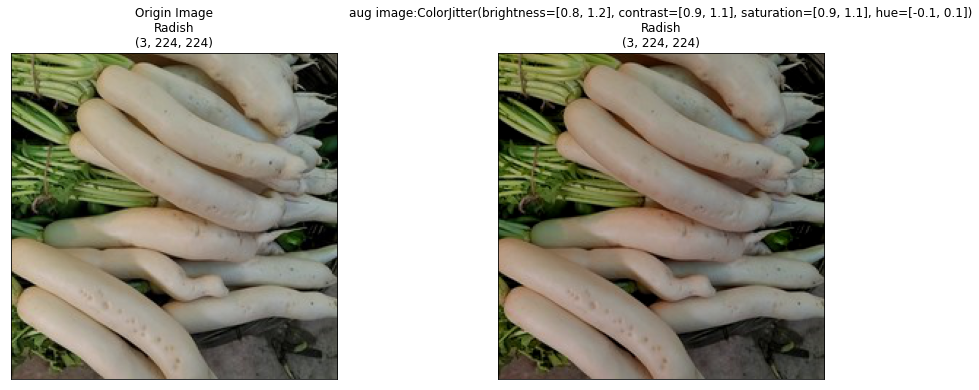

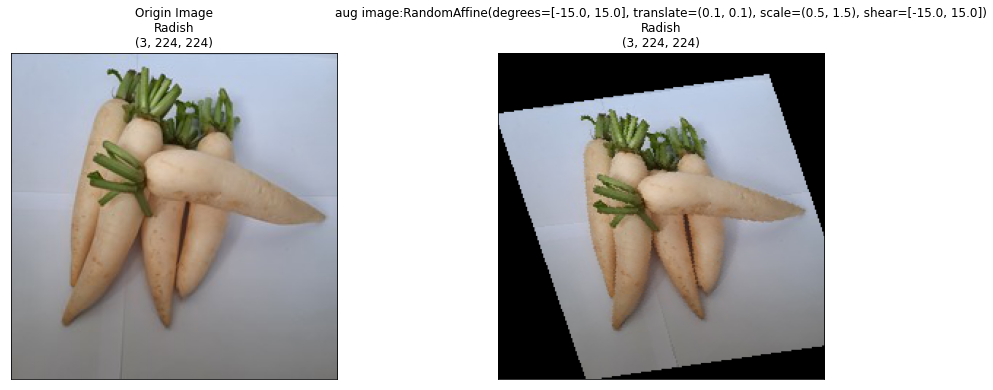

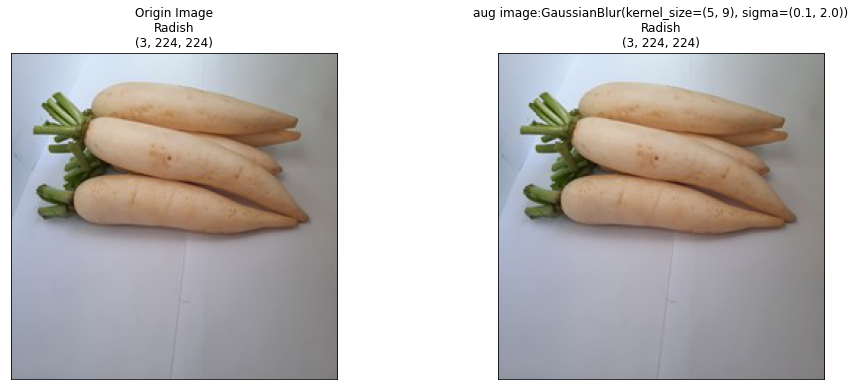

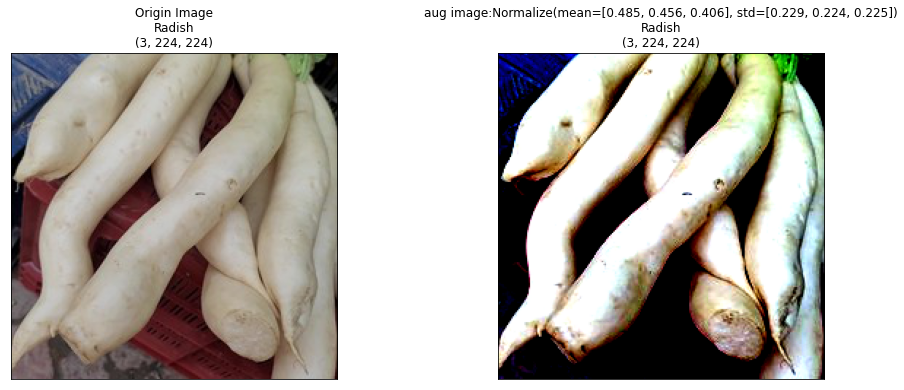

In [12]:
origin_and_aug_image_show(train_dir,augmentation_list)

In [13]:
class_names = train_dataset.classes
class_names[:5]

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli']

In [14]:
num_classes = len(class_names)
num_classes

15

## 데이터로더 정의

In [15]:
BATCH_SIZE = 32
train_dl = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2)
val_dl = DataLoader(valid_dataset, BATCH_SIZE, shuffle=True, num_workers=2)
test_dl = DataLoader(test_dataset, BATCH_SIZE, shuffle=True, num_workers=2)

In [16]:
# !pip install efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b7')

model=models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [17]:
print(f'vgg16 model summary:/n{model.named_parameters}')

vgg16 model summary:/n<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
   

## layer freeze

In [18]:
for param in model.parameters():
    param.requires_grad = False
    
    # requires_grad 기울기 저장 

## 마지막 레이어 수정 (1000에서 분류할 클래수 숫자 15개로)

In [19]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [20]:
model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [21]:
model.classifier[-1].in_features

4096

In [22]:
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

In [23]:
model.classifier[-1]

Linear(in_features=4096, out_features=15, bias=True)

In [24]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [25]:
torch.save(model.state_dict(), 'vgg_weights.pt')

## 오차함수 옵티마이저 스케쥴러 설정

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## 훈련 함수

In [27]:
def train(model,epochs,train_dl,valid_dl,train_data_percent,lr_scheduler,model_name):
    # 모델 , 에포크, 훈련셋, 시험셋, 훈련셋 비율 0.2면 훈련셋의 20%만 사용, 스케쥴러, 모델 이름
    model.to(device)
    max_acc = 0.0
    torch.save(model.state_dict(), f'best_weight_of_{model_name}.pt')
    loss_hist_train = [0] * epochs
    print(loss_hist_train)
    accuracy_hist_train = [0] * epochs
    print(accuracy_hist_train)
    loss_hist_valid = [0] * epochs
    print(loss_hist_valid)
    accuracy_hist_valid = [0] * epochs
    print(accuracy_hist_valid)
    no_of_batches_to_train = int(round(len(train_dl) * train_data_percent))
    print(no_of_batches_to_train)
    
    for epoch in tqdm_notebook(range(epochs), desc = 'number of epochs completed'):
        model.train()
        count = 0
        for x_batch, y_batch in tqdm_notebook(train_dl, desc = 'number of training batches completed'):
            if train_data_percent !=1 and count > no_of_batches_to_train:
                break
            count += 1
            x_batch, y_batch = x_batch.to(device),y_batch.to(device) 
            pred = model(x_batch) #데이터(이미지) x_batch
            loss = loss_fn(pred,y_batch) # 예측값, 라벨값
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0) # item() 로스값 스칼라 
            #print(y_batch.size(0))
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            #print(is_correct)
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        #print(len(train_dl.dataset))
        
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        
        #검증셋
        model.eval()
        
        with torch.no_grad():
            for x_batch, y_batch in tqdm_notebook(valid_dl, desc='number of valid batches completed'):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred,y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        lr_scheduler.step()
        if accuracy_hist_valid[epoch] > max_acc: # 더 좋은 결과가 나올 때 마다 업데이트
            max_acc = accuracy_hist_valid[epoch]
            torch.save(model.state_dict(), f'best_weights_of_{model_name}.pt')
        print(f'epoch {epoch+1} accuracy:'
             f'{accuracy_hist_train[epoch]:.4f} val_accuracy:'
             f'{accuracy_hist_valid[epoch]:.4f}')
        
    return loss_hist_train, loss_hist_valid,accuracy_hist_train, accuracy_hist_valid
            
                
            
        

## 훈련 데이터의 20%로만 돌려보기 (약식)

In [28]:
epochs = 10

hist = train(model, epochs, train_dl , val_dl , 0.2 , scheduler , "model_0")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
94


number of epochs completed:   0%|          | 0/10 [00:00<?, ?it/s]

number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 1 accuracy:0.1445 val_accuracy:0.8877


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 2 accuracy:0.1740 val_accuracy:0.9167


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 3 accuracy:0.1749 val_accuracy:0.9323


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 4 accuracy:0.1787 val_accuracy:0.9393


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 5 accuracy:0.1787 val_accuracy:0.9337


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 6 accuracy:0.1792 val_accuracy:0.9360


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 7 accuracy:0.1804 val_accuracy:0.9403


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 8 accuracy:0.1809 val_accuracy:0.9370


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 9 accuracy:0.1805 val_accuracy:0.9413


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 10 accuracy:0.1803 val_accuracy:0.9390


In [29]:
def plot_learning_curves(hist):
    
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(1,2,1)
    ax.plot(x_arr, hist[0], '-o', label = 'train loss')
    ax.plot(x_arr, hist[1], '--<', label = 'valid loss')
    ax.set_title('loss', size= 20)
    ax.legend(fontsize = 15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, [x.cpu() for x in hist[2]], '-o', label = 'train acc')
    ax.plot(x_arr, [x.cpu() for x in hist[3]], '--<', label = 'valid acc')
    ax.set_title('accuracy', size=20)
    ax.legend(fontsize=15)
    ax.set_xlabel('epoch', size=15)
    ax.set_ylabel('accuracy', size=15)
    plt.show()
    

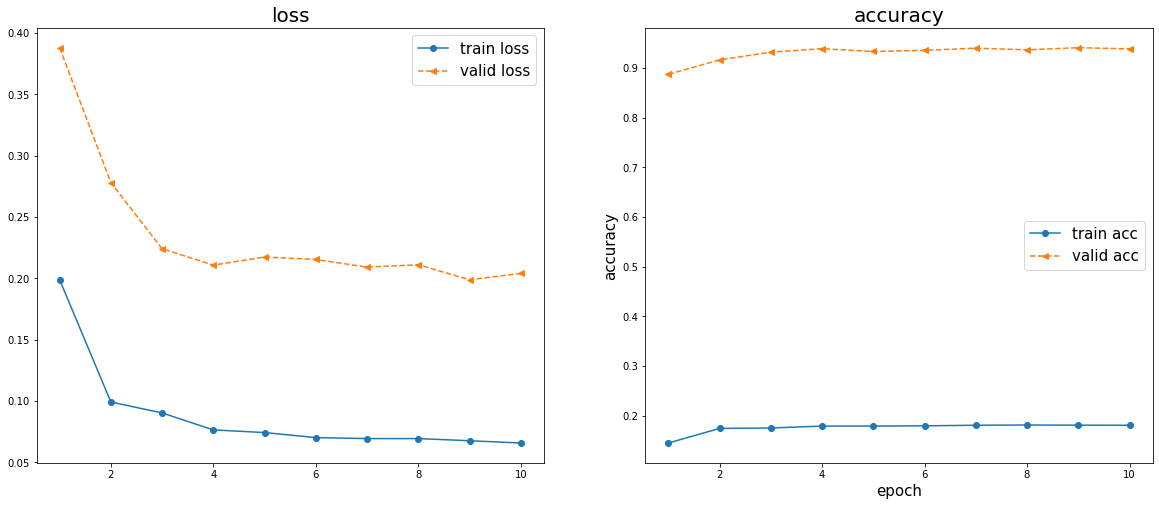

In [30]:
plot_learning_curves(hist)

## 테스트셋

In [31]:
def evaluate_test_dl(model, test_dl):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for x_batch, y_batch in tqdm_notebook(test_dl, desc = 'number of test batches completed'):
            x_batch, y_batch = x_batch.to(device),y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred,y_batch)
            test_loss += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred,dim=1) == y_batch).float()
            test_acc += is_correct.sum()
        test_loss /= len(test_dl.dataset)
        test_acc /= len(test_dl.dataset)
    return test_loss,test_acc.item()

In [32]:
model.load_state_dict(torch.load('./best_weights_of_model_0.pt'))


<All keys matched successfully>

In [33]:
test_loss, test_acc = evaluate_test_dl(model, test_dl)

number of test batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

In [34]:
print(f'loss {test_loss:.4f} acc {test_acc * 100:.2f}')




loss 0.2120 acc 94.27


### 훈련 데이터의 20%로만 훈련 했을 때 결과는 상당히 준수하다. 그럼 전체데이터는?

## 데이터 100%

In [35]:
model.load_state_dict(torch.load('/kaggle/working/vgg_weights.pt'))


<All keys matched successfully>

In [36]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

schduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [37]:
epochs = 10

hist_1 = train(model, epochs, train_dl, val_dl, 1, scheduler, 'model_1')

# 모델, 에포크, 훈련셋, 검증셋, 훈련셋 사용비중 100% (전부) , 스케쥴러, 모델이름 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
469


number of epochs completed:   0%|          | 0/10 [00:00<?, ?it/s]

number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 1 accuracy:0.8307 val_accuracy:0.9223


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 2 accuracy:0.8823 val_accuracy:0.9303


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 3 accuracy:0.8934 val_accuracy:0.9373


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 4 accuracy:0.8983 val_accuracy:0.9493


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 5 accuracy:0.8952 val_accuracy:0.9583


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 6 accuracy:0.9031 val_accuracy:0.9500


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 7 accuracy:0.9009 val_accuracy:0.9573


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 8 accuracy:0.9057 val_accuracy:0.9620


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 9 accuracy:0.9001 val_accuracy:0.9513


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 10 accuracy:0.9040 val_accuracy:0.9630


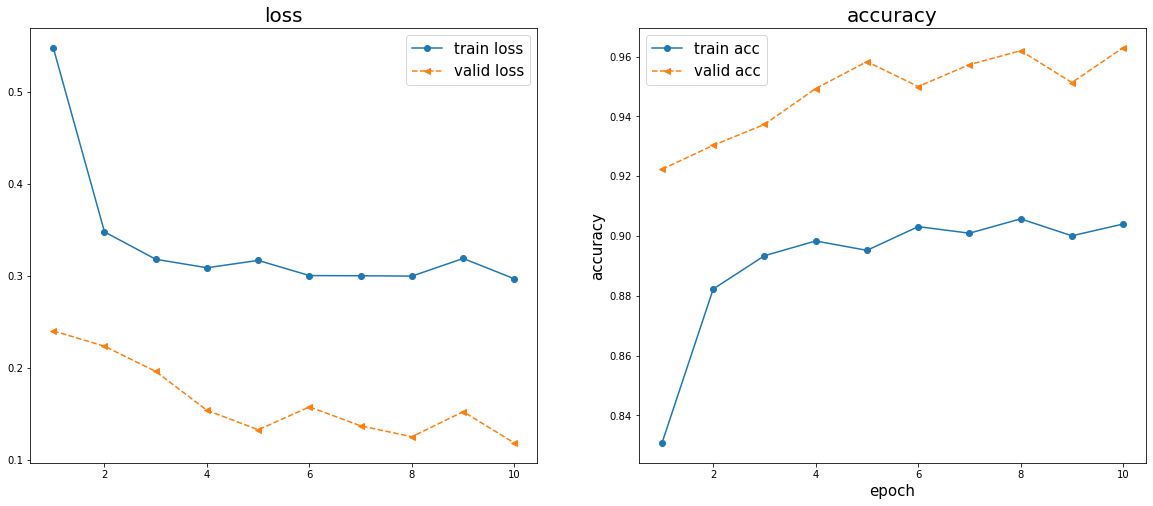

In [38]:
plot_learning_curves(hist_1)

In [39]:
model.load_state_dict(torch.load('./best_weights_of_model_1.pt'))


<All keys matched successfully>

In [40]:
test_loss,test_acc=evaluate_test_dl(model,test_dl)


number of test batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

In [41]:
print(f"loss {test_loss:.4f} acc {test_acc * 100:.2f}")

loss 0.1399 acc 96.13


### 전체 데이터를 사용하자 성능이 향상 되었습니다. 파인튜닝(미세조정)을 하면?

## fine tunning

In [42]:
model.load_state_dict(torch.load('/kaggle/working/best_weights_of_model_1.pt'))

<All keys matched successfully>

In [43]:
layers=[]
for param in model.parameters():
    layers.append(param)

In [44]:
# 마지막 10개의 레이어는 
for layer in layers[-10:]:
    layer.requires_grad=True
    

    
# pretrained model 들은 requires_grad = false로 두고 그대로 써도 좋은 결과를 보이지만 미세 조정을 함으로써 더 좋은 결과를 낼 수도 있다.

# 기존의 pretrained model의 설정은 그대로 두고 추가한 레이어에 대해서만 기울기를 저

# 프리징에 대한 글 https://jeonghyeokpark.netlify.app/pytorch/2020/11/27/pytorch1.html

In [45]:
print(layer)

Parameter containing:
tensor([ 0.0167, -0.0069,  0.0323, -0.0284,  0.0062, -0.0241, -0.0433,  0.0600,
        -0.0108, -0.0479,  0.0426, -0.0139, -0.0501,  0.0392,  0.0149],
       device='cuda:0', requires_grad=True)


In [46]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True


In [47]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

#5에포크마다 0.1씩 학습률 감소 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [48]:
epochs = 12
hist_2 = train(model, epochs, train_dl, val_dl, 1 , scheduler, 'model_2')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
469


number of epochs completed:   0%|          | 0/12 [00:00<?, ?it/s]

number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 1 accuracy:0.9265 val_accuracy:0.9880


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 2 accuracy:0.9633 val_accuracy:0.9817


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 3 accuracy:0.9713 val_accuracy:0.9907


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 4 accuracy:0.9769 val_accuracy:0.9823


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 5 accuracy:0.9821 val_accuracy:0.9947


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 6 accuracy:0.9903 val_accuracy:0.9963


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 7 accuracy:0.9928 val_accuracy:0.9980


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 8 accuracy:0.9948 val_accuracy:0.9970


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 9 accuracy:0.9949 val_accuracy:0.9973


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 10 accuracy:0.9950 val_accuracy:0.9970


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 11 accuracy:0.9964 val_accuracy:0.9970


number of training batches completed:   0%|          | 0/469 [00:00<?, ?it/s]

number of valid batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

epoch 12 accuracy:0.9953 val_accuracy:0.9977


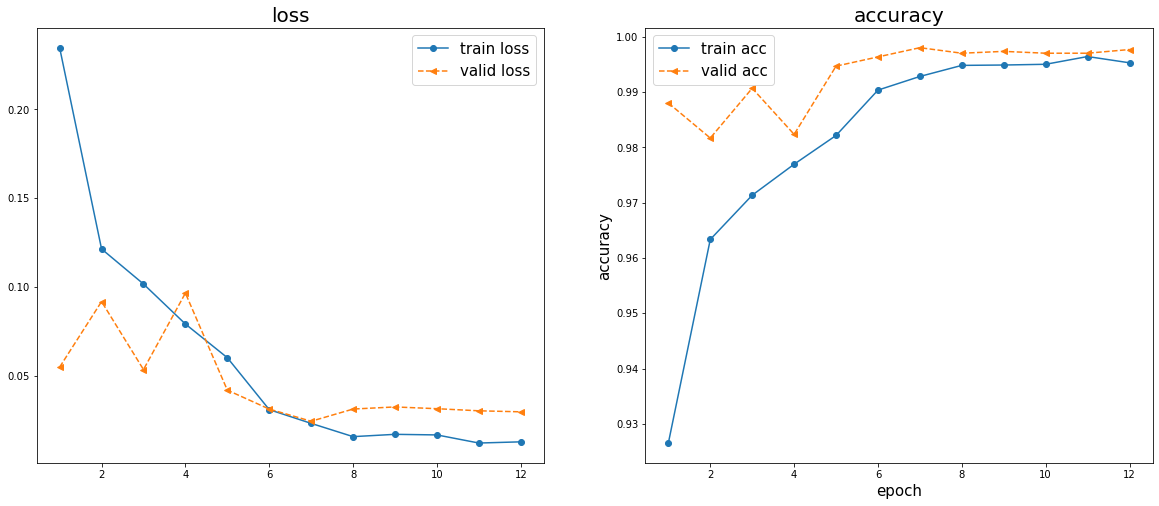

In [49]:
plot_learning_curves(hist_2)


In [50]:
model.load_state_dict(torch.load('/kaggle/working/best_weight_of_model_2.pt'))

<All keys matched successfully>

In [51]:
test_loss,test_acc=evaluate_test_dl(model,test_dl)


number of test batches completed:   0%|          | 0/94 [00:00<?, ?it/s]

In [52]:
print(f'loss {test_loss:.4f} acc {test_acc * 100:.2f}')

loss 0.1399 acc 96.13


### 파인 튜닝은 훈련셋 검증셋 성능 향상에 도움이 되었습니다. (잘 만든 전이학습 모델이라도 개선의 여지가 있다)

## 오류 분석

In [53]:
test_data = test_dataset.imgs

In [54]:
rows=[]
for img_path,label in tqdm_notebook(test_data):
    row={}
    row['img_path']=img_path
    row['true_label']=label
    img=torchvision.io.read_image(img_path)
    img=img.unsqueeze(0).to(device)
    pred=model(img/255.0)
    row['pred_label']=pred.argmax(dim=1).item()
    row['actual_class']=class_names[label]  
    row['pred_class']=class_names[row['pred_label']]
    rows.append(row)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [55]:
print(img_path, label)
print(img.shape)
print(pred[0])
print(pred)

/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Tomato/1200.jpg 14
torch.Size([1, 3, 224, 224])
tensor([ -9.9523, -16.5921, -10.4071,  -7.6451,  -9.8905,  -7.6592, -10.3752,
        -15.3740, -16.4504, -15.3733, -13.9800, -11.9260,  -5.8004,  -9.4553,
         -0.9842], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ -9.9523, -16.5921, -10.4071,  -7.6451,  -9.8905,  -7.6592, -10.3752,
         -15.3740, -16.4504, -15.3733, -13.9800, -11.9260,  -5.8004,  -9.4553,
          -0.9842]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [56]:
df = pd.DataFrame(rows)
df.head()

,img_path,true_label,pred_label,actual_class,pred_class
0,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,0,Bean,Bean
1,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,13,Bean,Radish
2,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,0,Bean,Bean
3,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,0,Bean,Bean
4,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,0,Bean,Bean


In [57]:
wrong_df=df.loc[df['true_label']!=df['pred_label']]


In [58]:
df.shape,wrong_df.shape

((3000, 5), (582, 5))

## 잘못된 예측 시각화

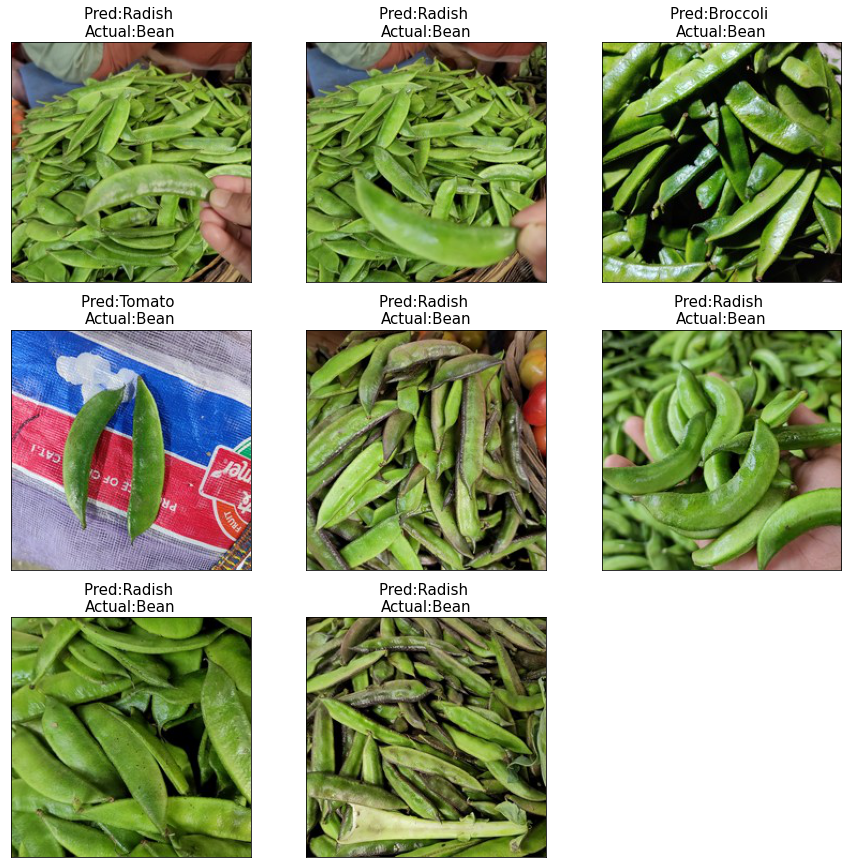

In [59]:
images_to_view=8
start_index=0
plt.figure(figsize=(15,15))
for i,row in enumerate(wrong_df[start_index:start_index+images_to_view].itertuples()):
    # itertuples 데이터의 인덱스, 열-값 정보를 map오브젝트의 튜플 형태로 반환하는 메서드 iterow 랑 비슷한 행단위로 반복처리하는 목적으로 사용 
    plt.subplot(3,3,i+1)
    _,img_path,tl,pl,tc,pc=row
    img=torchvision.io.read_image(img_path)
    plt.imshow(np.array(img).transpose(1,2,0))
    plt.title(f"Pred:{pc} \nActual:{tc}",size=15)
    plt.xticks([])
    plt.yticks([])
plt.show()


In [61]:
df.head()

,img_path,true_label,pred_label,actual_class,pred_class
0,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,0,Bean,Bean
1,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,13,Bean,Radish
2,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,0,Bean,Bean
3,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,0,Bean,Bean
4,/kaggle/input/vegetable-image-dataset/Vegetabl...,0,0,Bean,Bean


In [60]:

print(_) # 인덱스 번호 1 2 3 etc..
print(img_path) # 다음 열 이미지 주소 열
print(tl) # true label
print(pl) # pred label
print(tc) # true class
print(pc) # pred class

24
/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Bean/0102.jpg
0
13
Bean
Radish
